# MPI programs execution time prediction using Ridge, Cliques, ALS and ensemble algrithm

This notebook introduces MPI programs execution time prediction algorithm base on the following algorithms:
- Ridge regression
- Grouping computer installation based on Pearson correlation coefficient
- ALS matrix decomposition
- Ensemble of the algorithm above. Averaging ensemble is used.

Algorithms above predicts MPI program execution time on the certain set of computer installation. Computer installation is high-performance computing cluster, data center or supercomputer.

We use data from spec.org:
- MPI benchmarks [https://spec.org/mpi2007/results/mpi2007.html];
- OpenMP benchmarks [https://spec.org/accel/results/accel.html].

Data is constantly updated, so we add it to our repository too.

## Prerequisites
- Go to the directory with data sets
- Create some directories
- Install necessary packages

In [1]:
!ls -la ../data/benchmarks

total 96
drwxrwxr-x 6 andrew andrew  4096 Jul 12 14:55 .
drwxrwxr-x 3 andrew andrew  4096 Jul 12 14:45 ..
drwxrwxr-x 2 andrew andrew 20480 Jul 12 15:06 meta_mpi
drwxrwxr-x 2 andrew andrew 36864 Jul 12 14:43 mpi_logs
drwxrwxr-x 2 andrew andrew  4096 Jul 12 14:45 preprocessed
drwxrwxr-x 2 andrew andrew 20480 Jul 15 15:13 preprocessed_mpi


In [2]:
%cd ../data/benchmarks

/home/andrew/MSU/MC2E/third_stage/publications/Embeddings/code/CloudCom_2020_Embeddings/data/benchmarks


In [3]:
!mkdir ./preprocessed_mpi/
!mkdir ./meta_mpi/

mkdir: cannot create directory ‘./preprocessed_mpi/’: File exists
mkdir: cannot create directory ‘./meta_mpi/’: File exists


In [4]:
!rm ./preprocessed_mpi/*
!pwd

/home/andrew/MSU/MC2E/third_stage/publications/Embeddings/code/CloudCom_2020_Embeddings/data/benchmarks


In [5]:
!python --version

Python 3.6.10 :: Anaconda, Inc.


In [6]:
!conda install pandas numpy matplotlib scikit-learn scipy tqdm -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



## Parse csv with results of programs execution

In [7]:
import pandas as pd
import numpy as np
import glob
import random
from tqdm import tqdm

In [8]:
# Read data with MPI benchmarks executions on the different computer installation
for j, i in enumerate(glob.glob('./mpi_logs/*.csv')):
    print(i)
    accel = open(i,'r').readlines()
    f=open('./preprocessed_mpi/'+str(j) + ".csv", 'w')
    f.write("".join(accel[accel.index('"Selected Results Table"\n')+2:accel.index('"Selected Results Table"\n')+16]))
    f.close()
    f=open('./meta_mpi/'+str(j)+".csv", 'w')
    try:
        #f.write("".join(accel[accel.index('HARDWARE\n'):accel.index('"General Notes"\n')]))
        f.write("".join(accel[accel.index('HARDWARE\n'):accel.index('"Node Description: NFS"\n')]))
    except:
        f.write("".join(accel[accel.index('HARDWARE\n'):]))
    f.close()

logs =[]
for i in glob.glob('./preprocessed_mpi/*'):
    logs.append(pd.read_csv(i))

./mpi_logs/mpi2007-20181218-00602.csv
./mpi_logs/mpi2007-20120221-00367.csv
./mpi_logs/mpi2007-20140808-00450.csv
./mpi_logs/mpi2007-20090714-00150.csv
./mpi_logs/mpi2007-20130820-00409.csv
./mpi_logs/mpi2007-20150414-00481.csv
./mpi_logs/mpi2007-20190610-00636.csv
./mpi_logs/mpi2007-20090428-00137.csv
./mpi_logs/mpi2007-20190610-00628.csv
./mpi_logs/mpi2007-20120221-00348.csv
./mpi_logs/mpi2007-20100907-00238.csv
./mpi_logs/mpi2007-20090714-00142.csv
./mpi_logs/mpi2007-20120221-00371.csv
./mpi_logs/mpi2007-20100921-00246.csv
./mpi_logs/mpi2007-20120207-00347.csv
./mpi_logs/mpi2007-20080226-00040.csv
./mpi_logs/mpi2007-20090714-00145.csv
./mpi_logs/mpi2007-20150414-00482.csv
./mpi_logs/mpi2007-20130903-00415.csv
./mpi_logs/mpi2007-20140106-00425.csv
./mpi_logs/mpi2007-20140819-00466.csv
./mpi_logs/mpi2007-20100119-00196.csv
./mpi_logs/mpi2007-20110621-00325.csv
./mpi_logs/mpi2007-20200324-00640.csv
./mpi_logs/mpi2007-20081225-00088.csv
./mpi_logs/mpi2007-20100309-00216.csv
./mpi_logs/m

In [9]:
# Prepare data for PC matrix creation

computers={}
for j,i in enumerate(logs):
    if i['Base Run Time'].iloc[0] =='NC':
        continue
    computers[j]={'Run Time': i['Base Run Time']}
    if i['Benchmark'].iloc[0] == '121.pop2':
        computers[j]['class'] = 1
    else:
        computers[j]['class'] = 2

class_1 = {}
class_2 = {}
for item in computers.items():
    if item[1]['class'] == 1:
        class_1[item[0]]=item[1]['Run Time']
    else:
        if np.isnan(item[1]['Run Time']).any():
            continue
        class_2[item[0]]=item[1]['Run Time']

In [10]:
# Prepare data for PC matrix creation
logs =[]
for i in glob.glob('./preprocessed/*'):
    logs.append(pd.read_csv(i))

computers={}
for j,i in enumerate(logs):
    computers[j]=i['Base Ratio']
df = pd.DataFrame.from_records(computers)    

## Choose appropriate data set
- MPIL2007 -- 12 programs, 163 computer installations
- MPIM2007 -- 13 programs, 396 computer installations
- ACCEL_OMP -- 15 programs, 25 computer installations

## Create PC matrix

In [11]:
# df= pd.DataFrame.from_records(class_1) # Mpi 12x163
df= pd.DataFrame.from_records(class_2) # Mpi 13*396
# df= pd.DataFrame.from_records(computers)  # Accel opemmp

In [12]:
df

,1,5,6,7,9,10,13,14,15,16,...,567,568,571,572,573,574,576,577,578,579
0,371.685835,473.320781,72.394681,105.805730,22.451001,98.644636,200.439129,642.503790,138.408304,291.710527,...,700.450441,77.993420,195.099621,37.015933,49.969667,94.267536,69.741274,521.405322,299.379583,20.551419
1,655.758729,1655.736209,238.169436,384.592714,87.169563,308.340003,628.265758,783.136883,346.280673,668.059706,...,2752.439729,198.710780,522.315083,129.692896,141.973919,262.695832,175.074419,1310.447833,1239.289179,78.573564
2,610.581702,1416.842258,222.455876,276.803203,375.052510,245.781611,451.371561,1039.125776,316.880947,519.744656,...,2048.784982,174.589395,378.621575,595.676356,343.708446,219.393237,157.927308,1532.753560,736.051366,346.043410
3,299.035648,656.979511,115.217125,159.649388,33.651591,143.386136,263.360703,779.138516,188.778525,218.402510,...,1251.507416,92.475809,171.599950,35.352488,68.164113,85.222701,73.802459,539.813014,396.981143,17.198605
4,711.024917,988.953733,249.130315,360.276378,135.070712,244.965720,432.795571,1119.874850,169.904947,431.473430,...,1564.977218,155.843740,348.962574,234.050970,176.070527,299.899224,117.820777,752.622984,622.090732,155.609302
5,897.348835,1432.736532,191.284300,360.437660,53.758398,177.304130,454.682011,1932.297376,169.368559,209.693742,...,1834.400077,127.335557,174.250727,82.605261,105.393508,125.451582,81.948381,943.384674,582.088413,41.150553
6,451.531209,1272.434239,164.329496,296.893979,146.693470,184.317128,414.915084,1710.567779,214.376446,266.319569,...,1748.201391,148.280404,228.462184,225.665622,154.375417,157.313124,106.581402,1036.390153,499.750078,138.269416
7,877.594549,1339.119094,188.516449,364.872744,80.734706,274.078201,563.328335,1192.297332,305.446546,458.517891,...,2155.550356,168.193930,361.122486,124.826211,120.220096,206.569093,137.115130,1170.634225,883.548321,61.501768
8,228.651650,583.864851,82.545693,139.818139,28.681536,106.564245,232.753883,618.629523,101.585243,223.974026,...,998.832703,65.454085,185.100061,44.893200,47.705121,83.972103,45.928531,453.712391,274.694363,23.892556
9,762.461641,1054.887075,171.016799,276.269952,56.535404,165.016914,420.900386,1092.229597,190.932408,238.209719,...,1545.730795,132.671938,191.105873,90.597040,96.953561,140.732926,90.980030,787.300462,515.790876,55.867164


## Matrix factorization

In [13]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [20, 10]
def runALS(A, R, n_factors, n_iterations, lambda_):
    n, m = A.shape
    W = 3 * np.random.rand(n, n_factors)
    H = 3 * np.random.rand(n_factors, m)
    A_copy = A
    A = A*R
    def get_error(A, W, H, R):
        return np.sum((np.invert(R) * np.abs(A_copy - np.dot(W, H))) / A_copy) /np.sum(np.invert(R))

    MSE_List = []
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            W[i] = np.linalg.solve(np.dot(H, np.dot(np.diag(Ri), H.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(H, np.dot(np.diag(Ri), A[i].T))).T
        #print("Error after solving for W Matrix:", get_error(A, W, H, R))

        for j, Rj in enumerate(R.T):
            H[:,j] = np.linalg.solve(np.dot(W.T, np.dot(np.diag(Rj), W)) + lambda_ * np.eye(n_factors),
                                     np.dot(W.T, np.dot(np.diag(Rj), A[:, j])))
        #print("Error after solving for H Matrix:", get_error(A, W, H, R))

        MSE_List.append(get_error(A, W, H, R))
        
    return W, H, MSE_List[-1]



## Some useful functions¶

In [16]:
def nul_2(df_2, cells, i=-1, j = -1):
    
    if i<0:
        i = random.choice(range(df_2.shape[0]))
    if j<0:
        j = random.choice(range(df_2.shape[1]))
    
    df_2[i, j] = 0
    return df_2, i, j 
def gen_X(df_2, cell):
    train = []
    df_np = df_2
    for i in range(df.shape[0]):
        if i != cell[0]:
            train.append(np.concatenate([df_np[i][:cell[1]], df_np[i][cell[1]+1:]]))
    return np.array(train)
    
def gen_Y(df_2, cell): 
    df_np = df_2
    return np.concatenate([df_np[:cell[0],cell[1]], df_np[cell[0]+1:,cell[1]]])
    
    
def gen_predict(df_2, cell):
    df_np = df_2
    return [np.concatenate([df_np[cell[0]][:cell[1]], df_np[cell[0]][cell[1]+1:]])]

## Ridge regression

In [17]:
from sklearn.linear_model import Ridge

In [18]:
def predict_Ridge(cells, df_np):
    diff = []
    res=[]
    for cell in cells:
        z = Ridge()
        z.fit(gen_X(df_np, cell), gen_Y(df_np, cell))
        y = z.predict(gen_predict(df_np, cell))
        res.append(y)
        #Создать результирующую матрицу
        diff.append(np.abs(y - A[cell[0],cell[1]]) / A[cell[0],cell[1]])
    #return np.mean(diff)
    return res

## Define error function to compare algorithms

In [19]:
def get_error(pred, true):
    return np.mean(np.abs(pred - true) / true)

## Define function to make outliers in source data sets

In [20]:
def mul_2(df_2, const=4, i=-1, j = -1):
    
    if i<0:
        i = random.choice(range(df_2.shape[0]))
    if j<0:
        j = random.choice(range(df_2.shape[1]))
    
    df_2[i, j] *=(0.01+random.random()) * const
    return df_2, i, j 

## Prediction algorithm based on grouping computer installation based on Pearson correlation coefficient

In [21]:
import networkx as nx
from networkx.algorithms.clique import find_cliques
from networkx.algorithms.approximation.clique import clique_removal
from networkx.algorithms.clique import enumerate_all_cliques

In [22]:
np.seterr(all='raise')
def predict_Clicks(cells, df_numpy):
#     print(df_numpy)
    CORR_THRESHOLD = 0.75
    index_rows = range(df.shape[0])# Which tasks to use to predict correlation
    task_id = 2
    df_numpy = np.array([df_numpy[i] for i in index_rows])

    import scipy.stats
    z=[]
    graph = {}
    for i in range(df.shape[1]):
        gr_ = {}
        for j in range(df.shape[1]):
            gr_[j] = scipy.stats.pearsonr(df_numpy[:,i], df_numpy[:,j])[0]
        graph[i]=gr_
    #return pd.DataFrame.from_records(graph)
    
    '''
    print("Networkx:")
    bins = []
    for i in find_cliques(G):
      bins.append(i)
    return bins
    #for k in find_cliques(G):
    #  print(k)
    '''

    def check_is_good(i, gr):
        for j in gr:
            if graph[i][j] < CORR_THRESHOLD:
                return False
        else:
            return True

    ''' Cliques '''
    bins=[set()]
    alone_nodes = [i for i in range(df.shape[1])]
    random.shuffle(z)
    for i in range(df.shape[1]):
        flag = 1
        for bin_ in bins:
            if check_is_good(i, bin_):
                bin_.add(i)
                flag=0
        if flag:
            bins.append({i})

    alone =[]
    for bin_ in bins:
        if len(bin_) <2:
            alone.append(bin_)
    for i in alone:
        bins.remove(i)
    #return bins


    def predict_by_bin(bin_, cell):
        #df_numpy = df.to_numpy()
        df_np = np.array([df_numpy[i] for i in index_rows])
        coefs = []
        predicts = []
        without_j = np.concatenate([df_np[:cell[0]], df_np[cell[0]+1:]])
        for i in bin_:
            if i!=cell[1]:
                try:
                    coef = np.mean( without_j[:, cell[1]] / without_j[:,i])
                except:
                    continue
                coefs.append(coef)
                predicts.append(df_numpy[cell[0], i] * coef)
        try:
            return np.abs(np.mean(predicts))
        except:
            return 0
        


    preds = {}
    c = 0
    res = []
    result = df_numpy.copy()
    #print(result.shape)
    for task_id in range(12):
        for c in range(len(bins)):
            for j in bins[c]:
                pred = []
                pred.append(predict_by_bin(bins[c], [task_id, j]))
                preds[j] = pred
                result[task_id,j] = np.mean(pred)
            #for j in bins[c]:
            #    res.append([ np.mean(preds[j]), np.max(preds[j]), j])
                
        
    return result

    # Create final matrix
    n=[]
    for i in res:
        n.append(i[0])
    return n    
    score = (np.mean(n) * (df_numpy.shape[1] - len(alone)) + predict_Ridge(cells, df_numpy) * (len(alone))) / df_numpy.shape[1]
    print(len(alone))
    return score

## Make prediction using Ridge Regression, ALS decomposition with K=1, grouping based on Pearson correlation coefficient and ensemble

In [23]:
A = df.to_numpy()
l_ = []
l__ =[]
points = [1, 5, 10, 15, 20, 27, 35, 45, 55, 65, 75, 85, 100, 118, 135, 150, 175, 200, 250, 300]
# points = range(1, 30, 2)


# Uncomment code below if you want add outliers to sources data sets
# for i in range(int(A.shape[0]*A.shape[1]/9)):
# # #     A,k,l = mul_2(A, 4)
#     A,k,l = mul_2(A, 10)

    
for point in tqdm(points):
    losses=[]
    ridge_losses =[]
    clicks_losses = []
    R = np.invert(np.zeros(A.shape, dtype=np.bool))    
    cells = []
    point = int(A.shape[0]*A.shape[1]*point/100)
    
    for i in range(point):
        R,k,l = nul_2(R, cells)
        cells.append((k,l))
    df_np = A*R
    ridge_losses = predict_Ridge(cells, df_np)
    W_, H_, loss = runALS(A, R, n_factors = 1, n_iterations = 2, lambda_ = .3)
    
    clicks_losses = (predict_Clicks(cells, df_np))
    ridge_m = df_np.copy()
    decompose = df_np.copy()
    pr = W_ *H_
    for k, cell in enumerate(cells):
        ridge_m[cell[0], cell[1]] =  ridge_losses[k]
        decompose[cell[0], cell[1]] = pr[cell[0], cell[1]]
    
    clicks_l = ridge_m.copy()
    for k, cell in enumerate(cells):
        i=cell[0]
        j=cell[1]
        decompose[i,j] = (W_*H_)[i,j]
        if clicks_losses[i,j]>0:
            clicks_l[i,j] = clicks_losses[i,j]
    ensemble = np.average([decompose, ridge_m, clicks_l], axis=0, weights=[0.6,0.2,0.2])
    '''
    print((W_*H_).shape)
    print(A.shape)
    print(ridge_m)
    '''
    l_.append([np.sum(100*np.invert(R))/(A.shape[0]*A.shape[1]), get_error(decompose, A), get_error(ridge_m, A), get_error(ensemble,A), get_error(clicks_l, A)])


  0%|          | 0/20 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
  5%|▌         | 1/20 [00:12<03:56, 12.47s/it]/home/andrew/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 10%|█         | 2/20 [00:24<03:39, 12.21s/it]/home/andrew/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 15%|█▌        | 3/20 [00:33<03:15, 11.49s/it]/home/andrew/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 20%|██        | 4/20 [00:43<02:52, 10.80s/it]/home/andrew/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 25%|██▌       | 5/20 [00:51<02:33, 10.21s/it]/home/andrew/.local/lib/python3.6/site-pac

## Prepare to graph

In [24]:
ALS_losses = []
percents = []
ridge_losses = []
ensemble_losses = []
clicks_losses = []
for i,k in enumerate(points):
    ALS_losses.append(l_[i][1])
    percents.append(l_[i][0])
    ridge_losses.append(l_[i][2])
    ensemble_losses.append(l_[i][3])
    clicks_losses.append(l_[i][4])

max_index = -1
percents = percents[:max_index]
ALS_losses =   ALS_losses [:max_index]
ridge_losses = ridge_losses [:max_index]
ensemble_losses=ensemble_losses[:max_index]
clicks_losses =clicks_losses [:max_index]

print(np.array(ALS_losses).shape)
print(np.array(ridge_losses).shape)
print(np.array(clicks_losses))

(19,)
(19,)
[0.00228944 0.0129387  0.03093674 0.0471896  0.07059029 0.09298185
 0.15069377 0.18421907 0.23431804 0.28626829 0.31070997 0.36810823
 0.43997535 0.49662855 0.57675008 0.61108545 0.66795613 0.75852222
 0.83825469]


## Graphics

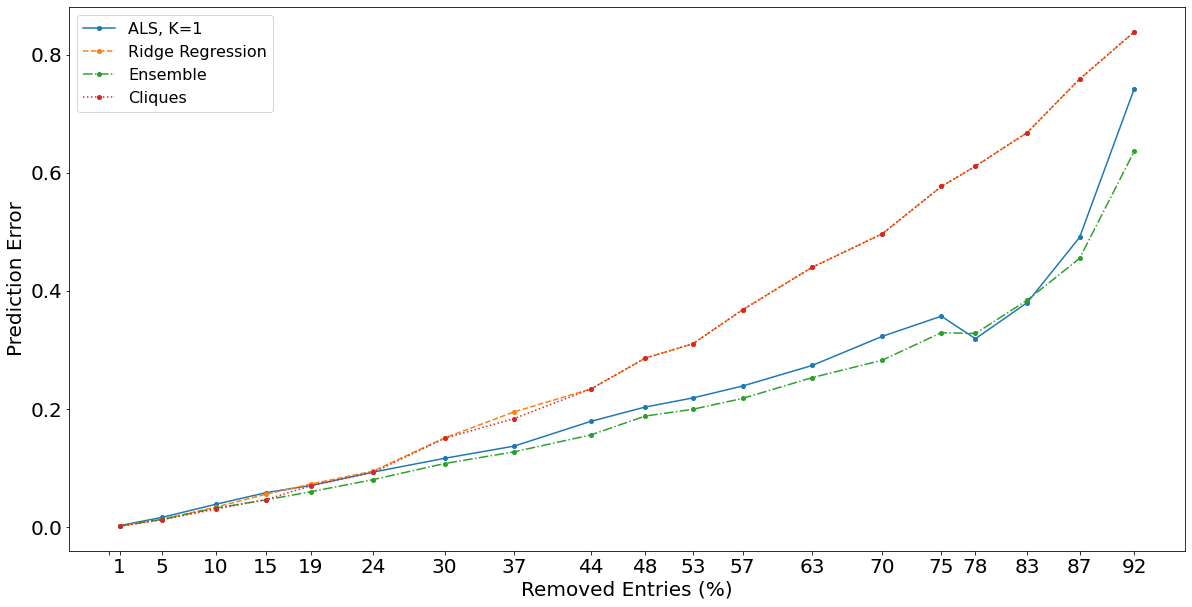

In [25]:
import math

# fig = plt.figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure()
ax = fig.add_subplot(111)

# plt.plot(range(0, len(ridge_losses) + 1), [1 for i in range(0, len(ridge_losses) + 1)], color="red")

plt.plot(percents, ALS_losses, linestyle='-', marker='o', markersize=4, label='ALS, K=1')
plt.plot(percents, ridge_losses, linestyle='--', marker='o', markersize=4, label='Ridge Regression')
plt.plot(percents, ensemble_losses, linestyle='-.', marker='o', markersize=4, label='Ensemble')
plt.plot(percents, clicks_losses, linestyle=':', marker='o', markersize=4, label='Cliques')


# Custom ticks, miss some values
xticks = [math.ceil(p) for p in percents]
# xticks = [int(p * 100) / 100.0 for p in percents]
xticks.insert(0, None)
# xticks[11] = None
# xticks[15] = None
# plt.xticks(range(0,len(points)+1), xticks, rotation=90, fontsize=14)
# 
plt.xticks([0] + percents, xticks, rotation=0, fontsize=20)
plt.yticks(fontsize=20)

plt.legend(prop={"size": 16})
plt.ylabel('Prediction Error', fontsize=20)
plt.xlabel('Removed Entries (%)', fontsize=20)
plt.show()